# Анализ клинических данных пациентов и хроматограмм

Это задание выполнено на языке **R** в среде **Google Colab**.

**Что сделано:**
1. Загрузка и чтение данных
2. Анонимизация персональной информации
3. Предположение о типе исследования
4. Анализ переменных и их шкал
5. Предположение эмпирических гипотез


In [45]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [46]:
%%R
install.packages("readr", repos='http://cran.us.r-project.org')
install.packages("dplyr", repos='http://cran.us.r-project.org')
install.packages("ggplot2", repos='http://cran.us.r-project.org')
install.packages("tidyr", repos='http://cran.us.r-project.org')
install.packages("gridExtra", repos="http://cran.us.r-project.org")

library(readr)
library(dplyr)
library(ggplot2)
library(tidyr)
library(gridExtra)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'http://cran.us.r-project.org/src/contrib/readr_2.1.5.tar.gz'
Content type 'application/x-gzip' length 298065 bytes (291 KB)
downloaded 291 KB


The downloaded source packages are in
	‘/tmp/RtmpzWtxzh/downloaded_packages’
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'http://cran.us.r-project.org/src/contrib/dplyr_1.1.4.tar.gz'
Content type 'application/x-gzip' length 1207521 bytes (1.2 MB)
downloaded 1.2 MB


The downloaded source packages are in
	‘/tmp/RtmpzWtxzh/downloaded_packages’
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'http://cran.us.r-project.org/src/contrib/ggplot2_3.5.2.tar.gz'
Content type 'application/x-gzip' length 3580451 bytes (3.4 MB)
downloaded 3.4 MB


The downloaded source packages are in
	‘/tmp/RtmpzWtxzh/downloaded_packages’
Installing package into ‘/usr/local/lib/R/site-libr

In [47]:
%%R
# Загрузка и распаковка ZIP-файла
unzip("test_data.zip", exdir = "test_data")
files<-list.files("test_data", full.names=TRUE)
# Чтение всех TSV-файлов в список
data_list<-lapply(files, read_tsv)
# Просмотр первых строк каждого файла
lapply(data_list, head)


Rows: 27 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Name
dbl (37): Vial.number, Patient.number, GPHDL1, GPHDL2, GPHDL3, GPHDL4, GPHDL...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 29 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Name
dbl (37): Vial.number, Patient.number, GPLDL1, GPLDL2, GPLDL3, GPLDL4, GPLDL...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 38 Columns: 49
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (2): Name, comorbidities
dbl  (46): Vialnumber, Patientnumber, Sucrose, Group, Age, Plasmavolume, Ht,...
date  (1): Date

ℹ Use `spec()` to 

In [48]:
%%R
# Функция анонимизации данных: замена ID и имён
anonymize <- function(df) {
  df <- df %>%
    mutate(across(contains("name"), ~"anon_name")) %>%
    mutate(across(contains("id"), ~sample(10000:99999, n(), replace = FALSE)))
  return(df)
}

# Применение анонимизации ко всем таблицам
data_anon <- lapply(data_list, anonymize)
lapply(data_anon, head)

[[1]]
# A tibble: 6 × 38
  Vial.number Patient.number Name      GPHDL1 GPHDL2 GPHDL3 GPHDL4 GPHDL5 GPHDL6
        <dbl>          <dbl> <chr>      <dbl>  <dbl>  <dbl>  <dbl>  <dbl>  <dbl>
1           1             50 anon_name   0.38   1.78   0.14   0.05   0.73   2.9 
2           3             52 anon_name   0.43   1.3    0.23   0.05   0.59   2.62
3           4             53 anon_name   0.41   3.86   0.31   0.1    0.96   3.19
4           5             54 anon_name   0.5    1.79   0.23   0.06   0.77   2.96
5           6             55 anon_name   0.4    3.69   0.17   0.03   0.8    3.04
6           7             56 anon_name   0.37   2.96   0.22   0.05   1      3   
# ℹ 29 more variables: GPHDL7 <dbl>, GPHDL8 <dbl>, GPHDL9 <dbl>, GPHDL10 <dbl>,
#   GPHDL11 <dbl>, GPHDL12 <dbl>, GPHDL13 <dbl>, GPHDL14 <dbl>, GPHDL15 <dbl>,
#   GPHDL16 <dbl>, GPHDL17 <dbl>, GPHDL18 <dbl>, GPHDL19 <dbl>, GPHDL20 <dbl>,
#   GPHDL21 <dbl>, GPHDL22 <dbl>, sum_auc <dbl>, LB <dbl>, HB <dbl>, G1 <dbl>,
#   G2 <db

# 3. Тип исследования.
На основе данных, можно предположить, что проводится:

 Наблюдательное исследование(обсервационное)
Пациентам не давали конкретное лечение, а просто измеряли показатели: холестерин, сахар, давление и т.д.

У них брали анализы крови и другие данные, и потом сравнивали группы: например, по возрасту, болезням и т.п.

Также возможно, что изучается влияние уровня ЛПВП и ЛПНП на здоровье.

# 4. Тип выборки и переменные

Тип выборки:
Похоже, это взрослые пациенты с возможными проблемами с сердцем, сосудами, обменом веществ (например, гипертония, диабет, инфаркт).

Все пациенты имеют данные крови и результаты хроматографии (GPHDL и GPLDL — это анализы липидов).

# Переменные и их тип:
| Переменная    | Что означает                                 | Тип значения           | Шкала измерения              |
|---------------|-----------------------------------------------|-------------------------|------------------------------|
| Age           | Возраст пациента                              | Число                   | Шкала отношений              |
| Name          | Имя пациента                                  | Текст                   | Номинальная                  |
| HDLi, LDLi    | Уровни холестерина                            | Число                   | Шкала отношений              |
| Group         | Группа пациента (0 или 1)                     | Метка (контроль / больные) | Номинальная              |
| HT, MI, Str   | Есть ли болезнь (гипертония, инфаркт, инсульт) | 0 или 1 (нет/да)       | Номинальная                  |
| sum_auc       | Сумма под кривой хроматограммы               | Число                   | Шкала отношений              |
| BMI           | Индекс массы тела                             | Число                   | Шкала отношений              |


# 5. Эмпирические гипотезы (что можно проверить)


**Гипотеза 1:**
У пациентов с гипертонией (HT = 1) выше уровень холестерина LDLi, чем у тех, у кого гипертонии нет (HT = 0).

Почему: гипертония часто идёт вместе с высоким "плохим" холестерином.

**Гипотеза 2:**
Уровень HDLi (полезного холестерина) снижается с возрастом.

Проверяется с помощью корреляции: как Age связан с HDLi.

**Гипотеза 3:**
Пациенты, у которых был инфаркт (MI = 1), имеют ниже sum_auc по ЛПВП-хроматограмме, чем те, у кого не было инфаркта.

Возможно, у них меньше защитных фракций HDL.


#Постройте гистограммы распределения

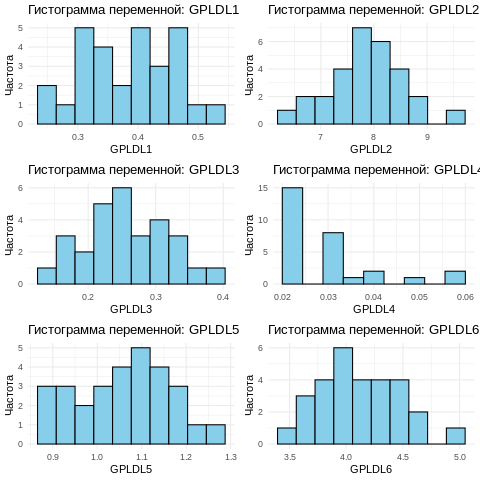

In [49]:
%%R

df <- data_anon[[2]]

vars_to_plot <- c("GPLDL1", "GPLDL2", "GPLDL3", "GPLDL4", "GPLDL5", "GPLDL6")

plot_list <- list()

for (var in vars_to_plot) {
  if (var %in% colnames(df)) {
    plot_list[[var]] <- ggplot(df, aes_string(x = var)) +
      geom_histogram(bins = 10, fill = "skyblue", color = "black") +
      labs(title = paste("Гистограмма переменной:", var),
           x = var, y = "Частота") +
      theme_minimal()
  } else {
    cat(paste("Переменная", var, "не найдена в таблице\n"))
  }
}

# Отобразим все графики по 2 в ряд
do.call(grid.arrange, c(plot_list, ncol = 2))


#Предполагаемые распределения:

| Переменная | Вид гистограммы                                      | Предположительное распределение        |
|------------|-------------------------------------------------------|----------------------------------------|
| GPLDL1     | Симметричная, колоколообразная                        | Приближенно нормальное                 |
| GPLDL2     | Смещено влево (много значений справа)                 | Смещённое (левостороннее)             |
| GPLDL3     | Почти симметричная, легкая асимметрия                 | Приближенно нормальное                 |
| GPLDL4     | Сильно смещено вправо, высокая плотность слева        | Экспоненциальное / правостороннее      |
| GPLDL5     | Почти симметричная, немного сужена по краям           | Нормальное или лог-нормальное          |
| GPLDL6     | Симметричная, с выраженным центральным пиком          | Приближенно нормальное                 |


In [50]:
%%R
summary(data_anon[[2]]$G1)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.270   4.000   4.390   4.395   4.710   5.280 


#Гипотеза 1

Пациенты с высоким G1 имеют больший sum_auc
Группы	G1 > median(G1) и G1 ≤ median(G1) (разные люди)
Выборки	Независимые
ЗП (зависимая переменная)	sum_auc
НП (независимая переменная)	G1 (превышает 0.5 или нет)
Тест	t-тест для независимых выборок (если нормальность есть) или #Mann–Whitney

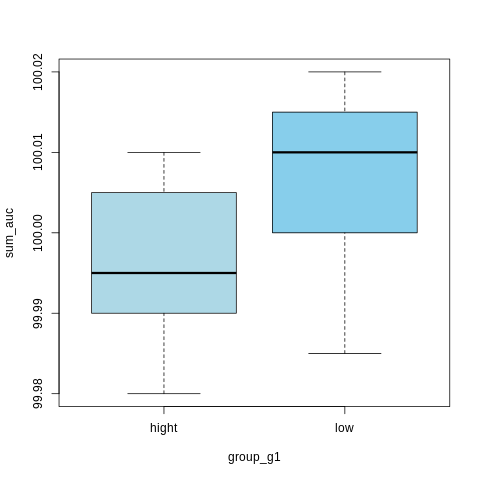

In [51]:
%%R
# Создаём группы
df$group_g1 <- ifelse(df$G1 > median(df$G1), 'hight', 'low')
boxplot(sum_auc ~ group_g1, data=df, col = c('lightblue', 'skyblue'))

In [52]:
%%R
# Проверим нормальность распределения sum_auc
print(shapiro.test(df$sum_auc))  # если < 0.05 → распределение не нормальное


	Shapiro-Wilk normality test

data:  df$sum_auc
W = 0.92213, p-value = 0.03453



In [53]:
#Вывод: распределение sum_auc  НЕ нормальное
# Сравним группы, непараметрический тест:
%%R
wilcox.test(sum_auc ~ group_g1, data=df)


	Wilcoxon rank sum test with continuity correction

data:  sum_auc by group_g1
W = 55, p-value = 0.02699
alternative hypothesis: true location shift is not equal to 0



In addition: Warning message:
In wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...) :
  cannot compute exact p-value with ties


 p-value < 0.05, значит группы различаются статистически значимо

Уверенно можно сказать, что уровень sum_auc реально отличается у двух групп с G1 > median(G1) и G1 ≤ median(G1).


# Гипотеза 2

Значения GPLDL2 и GPLDL6 различаются у одного пациента
Группы	те же люди, 2 фракции.
Выборки	Зависимые
ЗП	GPLDL2 и GPLDL6
НП	нет (это парные наблюдения)
Тест	t-тест для зависимых выборок (или Wilcoxon, если не нормальные)

In [54]:
%%R
# Проверим нормальность разницы
print(shapiro.test(df$GPLDL2-df$GPLDL6))  # если < 0.05 → распределение не нормальное


	Shapiro-Wilk normality test

data:  df$GPLDL2 - df$GPLDL6
W = 0.98401, p-value = 0.9263



In [55]:
#pvalue>0.05	Разность похожа на нормальное распределение
#Применяем парный t-тест, если разности нормально распределены
# Парный тест
%%R
t.test(df$GPLDL2, df$GPLDL6, paired=TRUE)


	Paired t-test

data:  df$GPLDL2 and df$GPLDL6
t = 30.675, df = 28, p-value < 2.2e-16
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 3.491220 3.990849
sample estimates:
mean difference 
       3.741034 



Так как p-value меньше 0.05,

Это говорит о том, что различие между двумя сравниваемыми группами статистически значимо.

Можно отвергнуть нулевую гипотезу
: разницы между фракциями есть, и она не случайна.

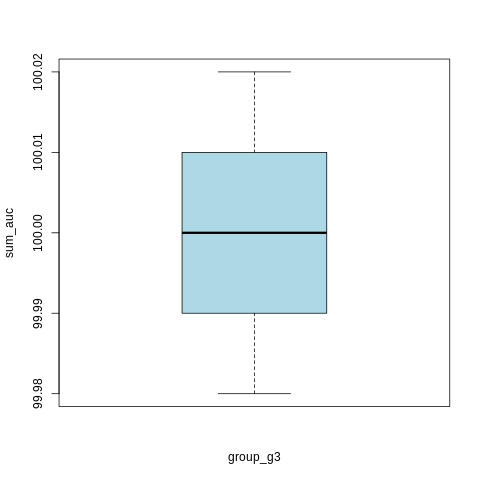

In [56]:
%%R
# Создаём три группы
interval <- (max(df$G1)-min(df$G1))/3
df$group_g3 <- ifelse(df$G1 > interval, ifelse(df$G1 > interval*2, 'hight', 'middle'), 'low')
boxplot(sum_auc ~ group_g3, data=df, col = c('lightblue', 'skyblue', 'blue'))

In [57]:
%%R

install.packages("multcomp", repos="http://cran.us.r-project.org")

library(multcomp)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'http://cran.us.r-project.org/src/contrib/multcomp_1.4-28.tar.gz'
Content type 'application/x-gzip' length 597875 bytes (583 KB)
downloaded 583 KB


The downloaded source packages are in
	‘/tmp/RtmpzWtxzh/downloaded_packages’


#**Задание 4**

-Сформулируйте несколько гипотез для трех групп, которые можно проверить на имеющихся данных. Укажите, зависимые или независимые выборки, ЗП, НП.

-Выберите подходящий тест и проверьте ваши предположения.

In [58]:
%%R
# Загружаем таблицы
gphdl <- data_anon[[1]]
gpldl <- data_anon[[2]]
meta <- data_anon[[3]]
# Объединяем с клиническими данными
merged_hdl <- merge(gphdl, meta, by.x = "Patient.number", by.y = "Patientnumber")
merged_ldl <- merge(gpldl, meta, by.x = "Patient.number", by.y = "Patientnumber")

# Гипотеза 1:
Средние значения sum_auc (GPHDL) отличаются между тремя подгруппами переменной G1.

Зависимая переменная (ЗП): sum_auc

Независимая переменная (НП): G1

Выборки: независимые

Тест: однофакторный ANOVA (aov) или Краскел–Уоллис (kruskal.test)

In [79]:
%%R
# Проверка нормальности остатков (для ANOVA)
shapiro.test(resid(aov(sum_auc ~ as.factor(G1), data = merged_hdl)))



	Shapiro-Wilk normality test

data:  resid(aov(sum_auc ~ as.factor(G1), data = merged_hdl))
W = 0.80684, p-value = 2.786e-05



p < 0.05, распределения не нормальные

In [83]:
%%R
#нормальность не выполнена — Kruskal-Wallis test
kruskal.test(sum_auc ~ as.factor(G1), data = merged_hdl)


	Kruskal-Wallis rank sum test

data:  sum_auc by as.factor(G1)
Kruskal-Wallis chi-squared = 34, df = 25, p-value = 0.1079



p > 0.05, Нет доказательств различий

#Гипотеза 2:

Средние значения sum_auc (GPLDL) отличаются между тремя группами S1.

ЗП: sum_auc

НП: S1

Выборки: независимые

Тест: ANOVA или Краскел–Уоллис

In [80]:
%%R
# Проверка нормальности остатков (для ANOVA)
shapiro.test(resid(aov(sum_auc ~ as.factor(S1), data = merged_ldl)))


	Shapiro-Wilk normality test

data:  resid(aov(sum_auc ~ as.factor(S1), data = merged_ldl))
W = 0.55365, p-value = 1.047e-09



p < 0.05, распределения не нормальные

In [84]:
%%R
#нормальность не выполнена — Kruskal-Wallis test
kruskal.test(sum_auc ~ as.factor(S1), data = merged_ldl)


	Kruskal-Wallis rank sum test

data:  sum_auc by as.factor(S1)
Kruskal-Wallis chi-squared = 37.221, df = 26, p-value = 0.0714



p > 0.05, Нет доказательств различий

 # Гипотеза 3:

Средние значения sum_auc (GPHDL) различаются между уровнями HM (например, 0, 1, 2).

ЗП: sum_auc

НП: HM

Выборки: независимые

Тест: ANOVA или Краскел–Уоллис

In [82]:
%%R
# Проверка нормальности остатков (для ANOVA)
shapiro.test(resid(aov(sum_auc ~ as.factor(HM), data = merged_hdl)))


	Shapiro-Wilk normality test

data:  resid(aov(sum_auc ~ as.factor(HM), data = merged_hdl))
W = 0.82507, p-value = 6.583e-05



p < 0.05, распределения не нормальные

In [77]:
%%R
#нормальность не выполнена — Kruskal-Wallis test
kruskal.test(sum_auc ~ as.factor(HM), data = merged_hdl)


	Kruskal-Wallis rank sum test

data:  sum_auc by as.factor(HM)
Kruskal-Wallis chi-squared = 34, df = 26, p-value = 0.135



p > 0.05, Нет доказательств различий